# Modélisation : collaborative filtering

Principe : Proposer à un utilisateur A le même contenu qu'un utilisateur B sur la base d'intérêts similaires

Etapes :

Constituer la matrice des goûts utilisateur :
- chaque ligne : représente un utilisateur
- chaque colonne : représente un article

Le feedback des utilisateurs sera implicite : nbre de fois qu'un utilisateur à cliqué sur un article

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import pickle
from IPython import display
import matplotlib.pyplot as plt
import collections
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
articles_df = pd.read_csv('data/articles_metadata.csv')
articles_emb = pickle.load(open("data/articles_embeddings.pickle","rb"))

In [3]:
clicks_by_hour_df = pd.DataFrame()
for i in range(385):
    index = str(i).zfill(3)
    if i%10 == 0:
        print("Reading file index :",index)
    clicks_df = pd.read_csv('data/clicks/clicks_hour_'+index+'.csv')
    clicks_by_hour_df = clicks_by_hour_df.append(clicks_df)

Reading file index : 000
Reading file index : 010
Reading file index : 020
Reading file index : 030
Reading file index : 040
Reading file index : 050
Reading file index : 060
Reading file index : 070
Reading file index : 080
Reading file index : 090
Reading file index : 100
Reading file index : 110
Reading file index : 120
Reading file index : 130
Reading file index : 140
Reading file index : 150
Reading file index : 160
Reading file index : 170
Reading file index : 180
Reading file index : 190
Reading file index : 200
Reading file index : 210
Reading file index : 220
Reading file index : 230
Reading file index : 240
Reading file index : 250
Reading file index : 260
Reading file index : 270
Reading file index : 280
Reading file index : 290
Reading file index : 300
Reading file index : 310
Reading file index : 320
Reading file index : 330
Reading file index : 340
Reading file index : 350
Reading file index : 360
Reading file index : 370
Reading file index : 380


## Construction de la matrice de feedback utilisateur
On construit la matrice à partir des clicks (démontre l'intérêt d'un utilisateur)

In [4]:
clicks_df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,170835,1508207781378377,1508207781000,2,209122,1508207781268,4,3,2,1,25,2
1,170835,1508207781378377,1508207781000,2,289003,1508207811268,4,3,2,1,25,2
2,306892,1508207782230378,1508207782000,3,50644,1508208270611,4,4,20,1,25,2
3,306892,1508207782230378,1508207782000,3,211442,1508208475029,4,4,20,1,25,2
4,306892,1508207782230378,1508207782000,3,16346,1508208505029,4,4,20,1,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2564,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2565,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2566,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2567,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [5]:
clicks_by_hour_df.user_id.nunique()

322897

In [6]:
clicks_by_hour_df.shape

(2988181, 12)

In [7]:
clicks = clicks_by_hour_df[['user_id','click_article_id']]

In [8]:
clicks = clicks.rename(columns={'click_article_id':'article_id'})

In [9]:
clicks

,user_id,article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592
...,...,...
2564,10051,84911
2565,322896,30760
2566,322896,157507
2567,123718,234481


In [10]:
interests_df = clicks.groupby(['user_id','article_id']).size().reset_index(name='count')

In [11]:
interests_df

,user_id,article_id,count
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


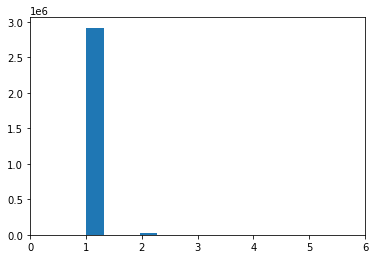

In [12]:
plt.hist(interests_df['count'],bins = 100);
plt.xlim((0,6));

## Factorisation de la matrice

On va la représenter sous la forme d'un sparse tensor qui permet d'économiser de l'espace mémoire

In [13]:
interests_df['user_id'].nunique()

322897

In [14]:
articles_emb.shape[0]

364047

## Construction d'un sparse tensor
Pour une représentation compacte de la matrice

In [15]:
def build_rating_sparse_tensor(interests_df):
    """
    Args:
    ratings_df: a pd.DataFrame with `user_id`, `article_id` and `count` columns.
    Returns:
    A tf.SparseTensor representing the interest matrix.
    """
    indices = interests_df[['user_id','article_id']].values
    values = interests_df['count'].values

    print("Building sparse tensor of shape :",interests_df['user_id'].nunique(),'x',articles_emb.shape[0])
    
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[interests_df['user_id'].nunique(), articles_emb.shape[0]])

In [16]:
interests_df

,user_id,article_id,count
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


In [17]:
interests_df[['user_id','article_id']].values

array([[     0,  68866],
       [     0,  87205],
       [     0,  87224],
       ...,
       [322895, 289197],
       [322896,  30760],
       [322896, 157507]])

In [18]:
interests_df['count'].values

array([1, 1, 1, ..., 1, 1, 1])

## Calcul de la MSE
fonction de cout qui travaille sur une matrice éparse... On effectue la multiplication de la matrice et on la compare à notre matrice

In [19]:
def sparse_mean_square_error(sparse_interests, user_embeddings, article_embeddings):
    """
    Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    article_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of article j.
    Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
    """
    predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_interests.indices[:, 0]) *
      tf.gather(article_embeddings, sparse_interests.indices[:, 1]),
      axis=1)

    loss = tf.losses.mean_squared_error(sparse_interests.values, predictions)
    
    return loss


## Factorisation de la matrice

In [20]:
# @title CFModel helper class (run this cell)
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

In [21]:
def build_model(interests, embedding_dim=3, init_stddev=1.):
    """
    Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
    model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(interests)
    # SparseTensor representation of the train and test datasets.
    # ========================= Complete this section ============================
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # ============================================================================
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    
    print("U shape:",U.shape)
    print("V shape:",V.shape)
    # ========================= Complete this section ============================
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    # ============================================================================
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "user_id": U,
      "article_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [22]:
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [23]:
# Build the CF model and train it.
model = build_model(interests_df, embedding_dim=50, init_stddev=0.5)


Building sparse tensor of shape : 321847 x 364047
Building sparse tensor of shape : 147019 x 364047
U shape: (321847, 50)
V shape: (364047, 50)


 iteration 500: train_error=1.403463, test_error=1.601952

[{'train_error': 1.4034635, 'test_error': 1.6019524}]

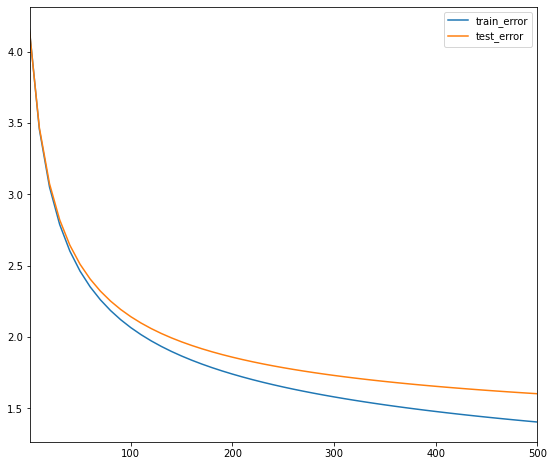

In [24]:
model.train(num_iterations=500, learning_rate=15.)

In [25]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
    Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    
    scores = u.dot(V.T)
    
    return scores

In [26]:
def user_recommendations(user_id,model, measure=DOT, exclude_rated=False, k=6):

    scores = compute_scores(
        model.embeddings["user_id"][user_id], model.embeddings["article_id"], measure)
    score_key = measure + ' score'
    
    print(scores.shape)
    print(interests_df.shape)
    
    df = pd.DataFrame({
        score_key: list(scores),
        'article_id': articles_df['article_id']
    })
    if exclude_rated:
        # remove movies that are already rated
        rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
        df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  



In [27]:
model.embeddings["user_id"][0]
#model.embeddings["article_id"].shape

array([ 0.23014876, -0.07038247,  0.49464843, -0.2489719 , -0.08469439,
        0.11469205, -0.08336939,  0.7603206 , -0.10055705,  0.04019361,
       -0.48961684, -1.1062245 , -0.2833936 ,  0.8560846 ,  0.00850858,
       -0.17839633,  0.32179946,  0.2392622 , -0.15164964,  0.6979087 ,
       -0.668592  ,  0.0359613 ,  0.3562292 ,  0.81349224, -0.8859336 ,
       -0.8620328 , -0.8168697 , -0.27180886,  0.49595204, -1.0065284 ,
        1.0695883 , -0.632652  ,  0.0793642 , -0.44883078, -0.00827198,
        1.0081793 ,  0.5035997 ,  0.53686935, -0.686958  , -0.89269197,
        0.17979728, -0.8196375 ,  0.3393189 ,  0.322131  ,  0.01724774,
        0.42478293,  0.5691692 ,  0.955105  , -0.07980312, -1.2821004 ],
      dtype=float32)

In [28]:
user_id = 0
user_recommendations(user_id,model, measure=COSINE, k=5)

(364047,)
(2950710, 3)


,cosine score,article_id
214783,0.578,214783
192879,0.562,192879
177356,0.560,177356
269092,0.546,269092
288535,0.541,288535


In [43]:
class TinyModel():
    
    def __init__(self,embeddings):
        self.embeddings = embeddings



pickle.dump(model.embeddings, open('model_collaborative.p',"wb"))

In [46]:
embeddings = pickle.load(open("model_collaborative.p","rb"))

In [47]:
test_model = TinyModel(embeddings)

user_recommendations(user_id,test_model, measure=COSINE, k=5)

(364047,)
(2950710, 3)


,cosine score,article_id
214783,0.578,214783
192879,0.562,192879
177356,0.560,177356
269092,0.546,269092
288535,0.541,288535
